# EECS 598 Convolutional Neural Network tutorial

Convolutional neural network tutorial is adapted from ( https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html, https://nextjournal.com/gkoehler/pytorch-mnist).

## Introduction

In this tutorial, we will cover:

* Convolutional layer
    - low level implementation of forward propagation
    - compare the result with PyTorch layer
* Average Pooling layer
    - low level implementation of forward propagation
    - low level implementation of backward propogation
    - compare the result with PyTorch layer
* Convolutional neural network
    - build and train the neural network with PyTorch
    - visualize learnt convolutional features

## Convolutional Layer
### 1. Forward propagation
We want to implement the forward pass for a convolutional layer. We input N images, each with C channels, height H and width W. We convolve each input with F different filters, where each filter is applied to all C channels and has height HH, width WW. 

#### Exercise: Low level implement of the forward propagation in convolutional layer (10 minutes)

In [15]:
import numpy as np
def conv_forward(x, w, b, stride, pad):
    """
    Input:
    - x: Input data of shape (N, C, H, W)
    - w: Filter weights of shape (F, C, HH, WW)
    - b: Biases, of shape (F,)
    - stride: The number of pixels between adjacent receptive fields in the
      horizontal and vertical directions.
    - pad: The number of pixels that will be used to zero-pad the input.
    Returns a tuple of:
    - out: Output data, of shape (N, F, H', W') where H' and W' are given by
      H' = 1 + (H + 2 * pad - HH) / stride
      W' = 1 + (W + 2 * pad - WW) / stride
    """
    out = None
  
    N, C, H, W = x.shape
    F, C, HH, WW = w.shape

    H_prime = int(1 + (H + 2 * pad - HH) / stride)
    W_prime = int(1 + (W + 2 * pad - WW) / stride)
    out = np.zeros((N, F, H_prime, W_prime))

    for i in range(N):
        # pad the image of shape C x H x W
        # pad 0 on top, bottom, left, right for the image
        x_temp = np.pad(x[i], [(0, 0), (pad, pad), (pad, pad)], 'constant')

        for j in range(H_prime):
            for k in range(W_prime):
                h_start = j * stride
                h_end = h_start + HH

                w_start = k * stride
                w_end = w_start + WW
                
                # local receptive field of shape C x HH x WW
                local_receptive_field = x_temp[:, h_start:h_end, w_start:w_end]

                # compute the features for each convolutional filter
                for f in range(F):
                    #In PyTorch or Tensorflow, the convolutional layer is implemented as cross-correlation
                    #because the filters are learned, it does not matter whether flipping is implemented for the filter
                    out[i, f, j, k] = np.sum(local_receptive_field * w[f]) + b[f]
                    #If you want to exactly implement convolution according to mathematical definition
                    #then flipping should be considered

    return out

Let's see the performance of our convolutional layer. We could get different convolutional features given different filters

/mnt/brain1/scratch/guoyijie/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


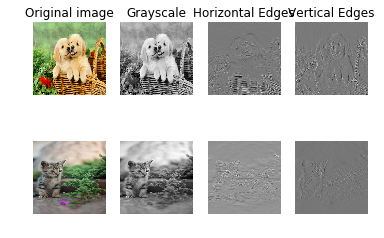

In [20]:
# Load the sample figures
from imageio import imread
from skimage.transform import resize

kitten, puppy = imread('kitten.jpg'), imread('puppy.jpg')

H, W = 400, 400
x = np.zeros((2, 3, H, W))
x[0, :, :, :] = resize(puppy, (H, W)).transpose((2, 0, 1))
x[1, :, :, :] = resize(kitten, (H, W)).transpose((2, 0, 1))


# Set up a convolutional weights holding 2 filters, each 3x3
w = np.zeros((3, 3, 3, 3))
#w = np.random.uniform(low=-10, high=10, size=(3,3,3,3))

# The first filter converts the image to grayscale.
# Set up the red, green, and blue channels of the filter.
w[0, 0, :, :] = [[0, 0, 0], [0, 0.3, 0], [0, 0, 0]]
w[0, 1, :, :] = [[0, 0, 0], [0, 0.6, 0], [0, 0, 0]]
w[0, 2, :, :] = [[0, 0, 0], [0, 0.1, 0], [0, 0, 0]]

# Second filter detects horizontal edges in the blue channel.
w[1, 2, :, :] = [[1, 2, 1], [0, 0, 0], [-1, -2, -1]]

# Third filter detects vertical edges in the blue channel
w[2, 2, :, :] = [[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]


# Vector of biases. We don't need any bias for the grayscale
# filter, but for the edge detection filter we want to add 128
# to each output so that nothing is negative.
b = np.array([0, 0, 0])

# Compute the result of convolving each input in x with each filter in w,
# offsetting by b, and storing the results in out.
out = conv_forward(x, w, b, stride=1, pad=1)

import matplotlib.pyplot as plt
def imshow_noax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    if img.ndim==3:
        plt.imshow(img.astype('uint8'))
    if img.ndim==2:
        plt.imshow(img.astype('uint8'), cmap='gray')
    plt.gca().axis('off')

def visualize(original_images, out_images):
    # Show the original images and the results of the conv operation
    plt.subplot(2, 4, 1)
    imshow_noax(original_images[0])
    plt.title('Original image')
    plt.subplot(2, 4, 2)
    imshow_noax(out_images[0, 0])
    plt.title('Grayscale')
    plt.subplot(2, 4, 3)
    imshow_noax(out_images[0, 1])
    plt.title('Horizontal Edges')
    plt.subplot(2, 4, 4)
    imshow_noax(out_images[0, 2])
    plt.title('Vertical Edges')    
    plt.subplot(2, 4, 5)
    imshow_noax(original_images[1])
    plt.subplot(2, 4, 6)
    imshow_noax(out_images[1, 0])
    plt.subplot(2, 4, 7)
    imshow_noax(out_images[1, 1])
    plt.subplot(2, 4, 8)
    imshow_noax(out_images[1, 2])
    plt.show()

visualize(x.transpose((0,2,3,1)),out)

The result of our implemented layer should be the same as the result of PyTorch layer

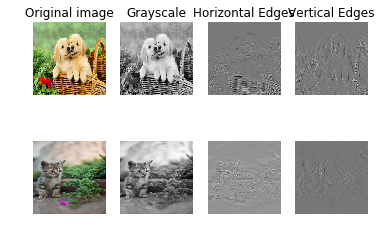

difference in the output: 3.70999707622e-08


In [21]:
import torch
import torch.nn as nn

weights = torch.Tensor(w).double()
bias = torch.Tensor(b).double()


conv = nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1, bias=True)

with torch.no_grad():
    conv.weight = nn.Parameter(weights)
    conv.bias = nn.Parameter(bias)
    out_new = conv.forward(torch.tensor(x))
    visualize(x.transpose((0,2,3,1)), np.array(out_new))

#compare the output from the conv layer we implemented and the conv layer in Pytorch
print('difference in the output:', np.abs(np.array(out_new)-out).max())

## Pooling Layer
### 1. Forward propagation

We want to implement the forward propagation of average pooling layer. We input N images with C channels, height H and width W. For each pooling region, the corresponding output is average of elements in the pooling region. The implementation of max pooling layer should be related with this implementation. You could think more about how to adapt the code as implementation of max pooling layer.

<img src="avgpool_forward.png" />

#### Exercise: Implement the forward propagation for average pooling layer (10 minutes)

In [6]:
def avg_pool_forward(x, kernel_size, stride):
    """
    A naive implementation of the forward pass for a average pooling layer.
    Inputs:
    - x: Input data, of shape (N, C, H, W)
    - kernel_size: The size of each pooling region
    - stride: The distance between adjacent pooling regions
    Returns a tuple of:
    - out: Output data of shape (N, C, H', W')
       H' = 1 + (H - kernel_size) / stride
       W' = 1 + (W - kernel_size) / stride
    """
    out = None
  
    N, C, H, W = x.shape

    H_prime = int(1 + (H - kernel_size) / stride)
    W_prime = int(1 + (W - kernel_size) / stride)

    out = np.zeros((N, C, H_prime, W_prime))

    for i in range(N):
        for j in range(H_prime):
            for k in range(W_prime):
                h_start = stride * j
                h_end = h_start + kernel_size

                w_start = stride * k
                w_end = w_start + kernel_size
                # Calculate the region of pooling window
                pool_window = x[i, :, h_start:h_end, w_start:w_end]
                pool_window = pool_window.reshape((C, -1))
                # Calculate the output correpsonding to the pooling window
                out[i, :, j, k] = np.mean(pool_window, axis=1)
    
    return out


Let's check the effect of the average pooling layer

/mnt/brain1/scratch/guoyijie/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


shape of original images (2, 3, 400, 400)
shape of pooled images (2, 3, 200, 200)


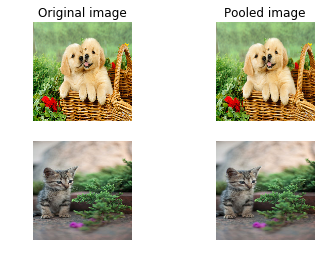

Shape of convolutional features (2, 6, 394, 394)
Shape of pooled features (2, 6, 197, 197)


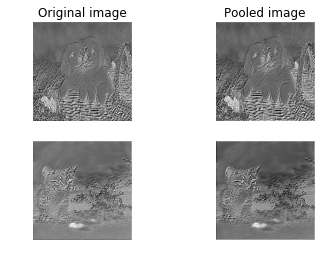

In [7]:
# Load the sample figures
from imageio import imread
from skimage.transform import resize

kitten, puppy = imread('kitten.jpg'), imread('puppy.jpg')

H, W = 400, 400
x = np.zeros((2, 3, H, W))
x[0, :, :, :] = resize(puppy, (H, W)).transpose((2, 0, 1))
x[1, :, :, :] = resize(kitten, (H, W)).transpose((2, 0, 1))

print('shape of original images', x.shape)
out = avg_pool_forward(x, kernel_size=2, stride=2)
print('shape of pooled images', out.shape)

def visualize(original_images, out_images):
    # Show the original images and the results of the pooling operation
    plt.subplot(2, 2, 1)
    imshow_noax(original_images[0])
    plt.title('Original image')
    plt.subplot(2, 2, 2)
    imshow_noax(out_images[0])
    plt.title('Pooled image')
    plt.subplot(2, 2, 3)
    imshow_noax(original_images[1])
    plt.subplot(2, 2, 4)
    imshow_noax(out_images[1])
    plt.show()

visualize(x.transpose((0,2,3,1)),out.transpose((0, 2, 3, 1)))

# if we apply average pooling for convolutional hidden units
conv1 = nn.Conv2d(3, 6, kernel_size=7, stride=1, padding=1, bias=True)
conv2 = nn.Conv2d(6, 6, kernel_size=5, stride=1, padding=1, bias=True)
conv_features = conv2.forward(conv1.forward(torch.Tensor(x)))
conv_features = conv_features.detach().numpy()
print('Shape of convolutional features', conv_features.shape)
out_conv = avg_pool_forward(conv_features, kernel_size=2, stride=2)
print('Shape of pooled features', out_conv.shape)
visualize(conv_features[:,0,:,:], out_conv[:,0,:,:])

Compare the result of our implemented layer and Pytorch layer

shape of original images (2, 3, 400, 400)
Shape of pooled images torch.Size([2, 3, 200, 200])


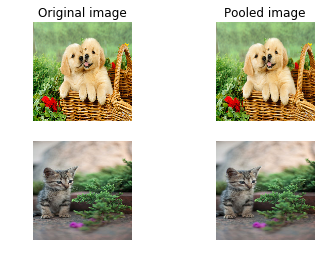

difference in the output: 0.0
Shape of convolutional features (2, 6, 394, 394)
Shape of pooled features (2, 6, 197, 197)


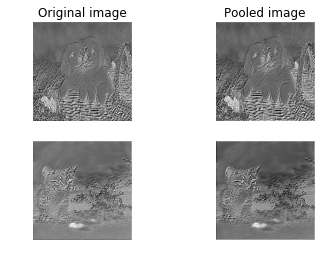

difference in the output: 0.0


In [8]:
print('shape of original images', x.shape)
pool = nn.AvgPool2d(kernel_size=2, stride=2)
out_new = pool.forward(torch.tensor(x))
print('Shape of pooled images', out_new.shape)

visualize(x.transpose((0,2,3,1)),np.array(out_new).transpose((0, 2, 3, 1)))

# compare the output of our implemented layer and PyTorch layer
print('difference in the output:', np.abs(np.array(out_new)-out).max())

# if we apply average pooling for convolutional hidden units
print('Shape of convolutional features', conv_features.shape)
out_conv_new = pool.forward(torch.Tensor(conv_features))
print('Shape of pooled features', out_conv.shape)
visualize(conv_features[:,0,:,:], np.array(out_conv_new)[:,0,:,:])
print('difference in the output:', np.abs(np.array(out_conv_new)-out_conv).max())

### 2.Backward Propagation

We want to implement the backward propagation of average pooling layer. We input the upstream derivatives of output of the foward pooling. And input the N images which we want to get the gradient with respect to. 

<img src="avgpool_backward.png" />

#### Exercise: Implement the backward propagation for average pooling layer (10 minutes)

In [9]:
def avg_pool_backward(dout, x, kernel_size, stride):
    """
    A naive implementation of the backward pass for a average pooling layer.
    Inputs:
    - dout: Upstream derivatives, of shape (N, C, H', W')
    - x: Input data, of shape (N, C, H, W)
    - kernel_size: The size of each pooling region
    - stride: The distance between adjacent pooling region
    Returns:
    - dx: Gradient with respect to x
    """
    dx = None
    N, C, H, W = x.shape

    H_prime = int(1 + (H - kernel_size) / stride)
    W_prime = int(1 + (W - kernel_size) / stride)

    dx = np.zeros_like(x)

    for i in range(N):
        for j in range(H_prime):
            for k in range(W_prime):
                h_start = stride * j
                h_end = h_start + kernel_size

                w_start = stride * k
                w_end = w_start + kernel_size

                for c in range(C):
                    # get the pool window in the input x
                    pool_window = x[i, c, h_start:h_end, w_start:w_end]

                    # get the gradient with respect to each element in the pooling window
                    dpool_window = np.ones_like(pool_window)/np.sum(np.ones_like(pool_window))
                    
                    # for the case that the pool window overlapping, the gradient should accumulated
                    dx[i, c, h_start:h_end, w_start:w_end] += dpool_window * dout[i, c, j, k]

    return dx

Let's compare the gradients we calculated and the gradients from PyTorch layer

In [12]:
dout = np.ones_like(out)
dx = avg_pool_backward(dout, x, kernel_size=2, stride=2)

pool = torch.nn.AvgPool2d(stride=2, kernel_size=2)
tensor_x = torch.tensor(x, requires_grad=True)
out_new = pool.forward(tensor_x)
out_new.backward(torch.ones_like(out_new))
dx_new = tensor_x.grad

print('difference in the gradient:', np.abs(np.array(dx_new)-dx).max())

difference in the gradient: 0.0


## Convolutional Neural Network
We will use the CIFAR10 dataset. It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

### 1. Loading and normalizing CIFAR10
The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [85]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images

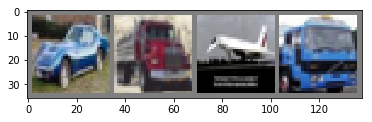

  car truck plane truck


In [87]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### 2. Define a Convolutional Neural Network
Copy the neural network from the Neural Networks section before and modify it to take 3-channel images (instead of 1-channel images as it was defined).

#### Exercise: define the convolutional neural network using PyTorch layers (10 minutes)

In [88]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # define the foward function 
        # conv1 - relu - pool - conv2 - relu - pool - fc1 - relu - fc2 -relu - fc3
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

### 3. Define a Loss function and optimizer

Let’s use a Classification Cross-Entropy loss and SGD with momentum.

In [89]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. Train the network

This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

In [90]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, (images, labels) in enumerate(trainloader):
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999:    # print every 2000 mini-batches
            print('[epoch %d, iter %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0

print('Finished Training')

[epoch 1, iter  1000] loss: 2.301
[epoch 1, iter  2000] loss: 2.203
[epoch 1, iter  3000] loss: 1.978
[epoch 1, iter  4000] loss: 1.823
[epoch 1, iter  5000] loss: 1.724
[epoch 1, iter  6000] loss: 1.675
[epoch 1, iter  7000] loss: 1.585
[epoch 1, iter  8000] loss: 1.557
[epoch 1, iter  9000] loss: 1.538
[epoch 1, iter 10000] loss: 1.504
[epoch 1, iter 11000] loss: 1.483
[epoch 1, iter 12000] loss: 1.420
[epoch 2, iter  1000] loss: 1.373
[epoch 2, iter  2000] loss: 1.378
[epoch 2, iter  3000] loss: 1.389
[epoch 2, iter  4000] loss: 1.362
[epoch 2, iter  5000] loss: 1.357
[epoch 2, iter  6000] loss: 1.356
[epoch 2, iter  7000] loss: 1.347
[epoch 2, iter  8000] loss: 1.282
[epoch 2, iter  9000] loss: 1.349
[epoch 2, iter 10000] loss: 1.274
[epoch 2, iter 11000] loss: 1.265
[epoch 2, iter 12000] loss: 1.292
Finished Training


### 5. Test the network on the test data

We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

torch.Size([4, 3, 32, 32])


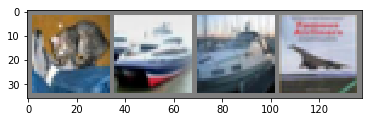

GroundTruth:    cat  ship  ship plane


In [91]:
dataiter = iter(testloader)
images, labels = dataiter.next()
print(images.shape)
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [92]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat   car  ship  ship


In [93]:
from math import sqrt, ceil
import numpy as np

def visualize_grid(Xs, ubound=255.0, padding=1):
    """
    Reshape a 4D tensor of image data to a grid for easy visualization.
    Inputs:
    - Xs: Data of shape (N, H, W, C)
    - ubound: Output grid will have values scaled to the range [0, ubound]
    - padding: The number of blank pixels between elements of the grid
    """
    (N, H, W, C) = Xs.shape
    grid_size = int(ceil(sqrt(N)))
    grid_height = H * grid_size + padding * (grid_size - 1)
    grid_width = W * grid_size + padding * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C))
    next_idx = 0
    y0, y1 = 0, H
    for y in range(grid_size):
        x0, x1 = 0, W
        for x in range(grid_size):
            if next_idx < N:
                img = Xs[next_idx]
                low, high = np.min(img), np.max(img)
                grid[y0:y1, x0:x1] = ubound * (img - low) / (high - low)
                next_idx += 1
            x0 += W + padding
            x1 += W + padding
        y0 += H + padding
        y1 += H + padding
    if(C==1):
        grid=grid[:,:,0]
    return grid



Visualizing the convolutional features for sample images
torch.Size([1, 6, 28, 28])
(86, 86)


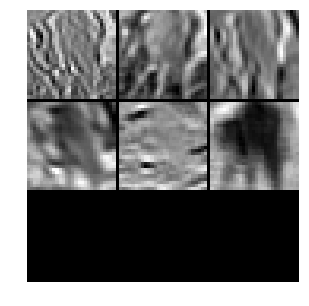

torch.Size([1, 16, 10, 10])
(43, 43)


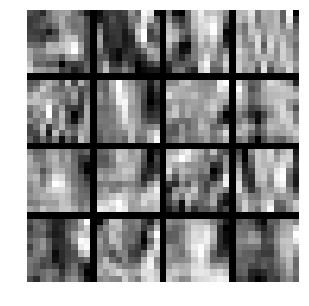

Visualizing the learnt filters
torch.Size([6, 3, 5, 5])
(17, 17, 3)


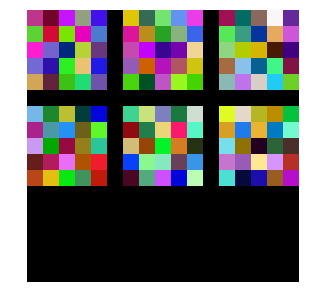

In [116]:
with torch.no_grad():
    print('Visualizing the convolutional features for sample images')
    conv1_features = net.conv1(images[[0],:,:,:])
    print(conv1_features.shape)
    grid = visualize_grid(conv1_features.numpy().transpose(1, 2, 3, 0))
    print(grid.shape)
    plt.imshow(grid.astype('uint8'), cmap='gray')
    plt.axis('off')
    plt.gcf().set_size_inches(5, 5)
    plt.show()
    conv2_features = net.conv2(net.pool(F.relu(net.conv1(images[[0],:,:,:]))))
    print(conv2_features.shape)
    grid = visualize_grid(conv2_features.numpy().transpose(1, 2, 3, 0))
    print(grid.shape)
    plt.imshow(grid.astype('uint8'), cmap='gray')
    plt.axis('off')
    plt.gcf().set_size_inches(5, 5)
    plt.show()
    print('Visualizing the learnt filters')
    filters= net.conv1.weight
    print(filters.shape)
    grid = visualize_grid(filters.detach().numpy().transpose(0,2,3,1))
    print(grid.shape)
    plt.imshow(grid)
    plt.axis('off')
    plt.gcf().set_size_inches(5, 5)
    plt.show()

Let us look at how the network performs on the whole dataset.

In [95]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 53 %


In [96]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 61 %
Accuracy of   car : 72 %
Accuracy of  bird : 28 %
Accuracy of   cat : 20 %
Accuracy of  deer : 42 %
Accuracy of   dog : 43 %
Accuracy of  frog : 68 %
Accuracy of horse : 78 %
Accuracy of  ship : 60 %
Accuracy of truck : 60 %


Due to the time constraint, we could not train the network for many more epochs to show the power of convolutional neural network for classification. Here we provide another example of image classification on MNIST. This dataset is not so challenging. So we could get high test accuracy on this dataset within only 3 epochs of traning.

Again, you just need to build the data loader, build network and optimzer, and then train and test the network.

In [55]:

transform = torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                   (0.5, 0.5), (0.5, 0.5))
                             ])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                        download=True, transform=transform)
testloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')

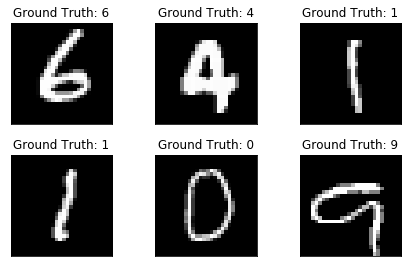

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# get some random training images
dataiter = iter(testloader)
images, labels = dataiter.next()

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(images[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(labels[i]))
    plt.xticks([])
    plt.yticks([])
fig

In [49]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [50]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)

In [51]:
n_epochs = 3
log_interval = 10
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(trainloader.dataset) for i in range(n_epochs + 1)]

In [52]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(trainloader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{}]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                , loss.item()))
        train_losses.append(loss.item())
        train_counter.append(
            (batch_idx*64) + ((epoch-1)*len(trainloader.dataset)))
        #torch.save(network.state_dict(), '/results/model.pth')
        #torch.save(optimizer.state_dict(), '/results/optimizer.pth')

In [53]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in testloader:
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(testloader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testloader.dataset),
        100. * correct / len(testloader.dataset)))

In [54]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

/mnt/brain1/scratch/guoyijie/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/mnt/brain1/scratch/guoyijie/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3106, Accuracy: 3131/60000 (5%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.296417
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.295190
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.319647
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.313823
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.302095
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.304306
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.305299
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.299213
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.283804
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.290875
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.298024
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.265569
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.263562
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.249155
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.252310
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.232271
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.228711
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.206352
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.206623
Train Epoch: 1 [12160/

Train Epoch: 2 [44160/60000 (74%)]	Loss: 0.620670
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.254743
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.341685
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.238987
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.336456
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.427252
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.530751
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.524673
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.400101
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.253874
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.338211
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.497951
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.363355
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.433326
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.377538
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.482585
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.395395
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.293610
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.095518
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.353133


### CONGRATULATIONS! YOU HAVE TRAINED A CONVOLUTIONAL NEURAL NETWORK FOR IMAGE CLASSIFICATION ON PYTORCH!